In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from geo_transform.tf_tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os
from utils.image import restore_original_image_from_array

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from utils import tf_session
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


# 1.Data load

In [4]:
from data_loader.dev_dataset import tf_image_process

In [5]:
_datapath = "sample_dataset"
filelist = os.listdir(_datapath)
input_size = (200, 200)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [6]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)
ds = tf.data.Dataset.from_tensor_slices(images)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(10)

In [7]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


In [ ]:
plt.imshow(images[1]/255)

In [ ]:
plt.imshow(A[1])

In [ ]:
plt.imshow(B[1])

# 2. Model definition

In [8]:
from models.cnngeo import CNN_geotransform

In [9]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [10]:
cnngeo = CNN_geotransform(feature_extractor, 18)
geo_parameters, correlations = cnngeo(A, B)
cnngeo.load_weights("cnngeo.h5")
cnngeo.summary()

Model: "cnn_geotransform"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 25, 25, 512)       7635264   
_________________________________________________________________
correlation_network (Correla multiple                  0         
_________________________________________________________________
spatial_regressor (Spatial_r multiple                  4384978   
Total params: 12,020,242
Trainable params: 12,019,858
Non-trainable params: 384
_________________________________________________________________


In [11]:
from models.module import feature_l2_normalization, normalize_correlation, generate_inlier_mask

class CNN_align(tf.keras.Model):
    def __init__(self, cnngeo):
        super(CNN_align, self).__init__()
        self.model_name = 'CNNalign'
        self.cnngeo = cnngeo
    def call(self, imageA, imageB):
        geo_parameters, correlations = self.cnngeo(imageA, imageB)       
        map_size = correlations.shape[-2:] #H,W
        inlier_masks = generate_inlier_mask(geo_parameters, tps, map_size)
        inlier_matching = correlations * inlier_masks  # B, H, W, H, W
        inlier_count = tf.reduce_sum(inlier_matching, axis=(1, 2, 3, 4))
        return correlations, inlier_matching, inlier_count

    def save(self, ckpt_path):
        self.cnngeo.save_weights(ckpt_path)

    def load(self, ckpt_path):
        self.cnngeo.load_weights(ckpt_path)

In [12]:
cnnalign = CNN_align(cnngeo)

In [13]:
correlations, inlier_matching, inlier_count = cnnalign(A,B)
cnnalign.summary()

(10, 625, 25, 25, 2)
Model: "cnn_align"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_geotransform (CNN_geotra multiple                  12020242  
Total params: 12,020,242
Trainable params: 12,019,858
Non-trainable params: 384
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0-rc2 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last solution i

# 3.Training

In [ ]:
def loss_fn(pred):
    return tf.reduce_mean(-pred)

@tf.function
def train_step(image_A, image_B, label, model, optimizer):
    with tf.GradientTape() as tape:
        correlations, inlier_matching, inlier_count = model(image_A, image_B)
        loss = loss_fn(inlier_count)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(2000):
    for step, (image_a, image_b, labels) in enumerate(ds):
        t_loss = train_step(image_a, image_b, labels, cnnalign, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

cnnalign.save("cnnalign.h5")

In [ ]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [ ]:
fig.savefig('cnnalign-train.png')

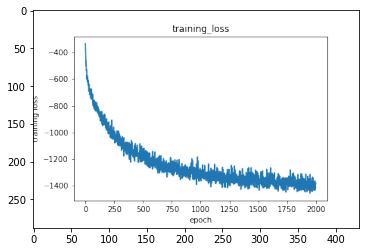

In [14]:
train_graph = plt.imread("cnnalign-train.png")
plt.imshow(train_graph)

# Test

In [15]:
cnnalign.load('cnnalign.h5')

In [16]:
correlations, inlier_matching, inlier_count = cnnalign(A,B)

(10, 625, 25, 25, 2)


In [17]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    correlations, inlier_matching, inlier_count = cnnalign(A, B)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 625, 25, 25, 2)


In [18]:
matches = tf.where(correlations*inlier_matching>0.3)

In [26]:
matches[matches[:,0] == 0]

<tf.Tensor: shape=(44, 5), dtype=int64, numpy=
array([[ 0,  0, 14,  0, 16],
       [ 0,  0, 15,  0, 17],
       [ 0,  0, 16,  0, 18],
       [ 0,  0, 17,  0, 19],
       [ 0,  0, 18,  0, 20],
       [ 0,  0, 19,  0, 21],
       [ 0,  0, 20,  0, 21],
       [ 0,  0, 20,  0, 22],
       [ 0,  0, 21,  0, 22],
       [ 0,  0, 22,  0, 23],
       [ 0,  0, 23,  0, 24],
       [ 0,  0, 24,  0, 24],
       [ 0,  1, 22,  0, 23],
       [ 0,  1, 23,  0, 24],
       [ 0,  1, 24,  0, 24],
       [ 0,  2, 23,  1, 24],
       [ 0,  2, 24,  1, 24],
       [ 0,  3, 23,  2, 24],
       [ 0,  4, 22,  3, 24],
       [ 0,  5, 22,  4, 24],
       [ 0, 13, 19, 13, 24],
       [ 0, 13, 19, 14, 24],
       [ 0, 14, 19, 14, 24],
       [ 0, 14, 19, 15, 24],
       [ 0, 15, 19, 15, 24],
       [ 0, 17, 21, 18, 24],
       [ 0, 18, 21, 19, 24],
       [ 0, 18, 22, 20, 24],
       [ 0, 19, 22, 20, 24],
       [ 0, 20,  0, 21,  0],
       [ 0, 20, 22, 21, 24],
       [ 0, 21, 23, 22, 24],
       [ 0, 22,  0, 23,  

In [20]:
H1, W1, C = img1.shape
H2, W2, C = img2.shape
campus = np.zeros([H1, W1+W2, C])

NameError: name 'img1' is not defined

In [21]:
campus.shape

NameError: name 'campus' is not defined

In [22]:
def draw_matches(img1, img2, map_size, coords):
    H1, W1, C = img1.shape
    H2, W2, C = img2.shape
    campus = np.zeros([H1, W1+W2, C])
    campus[:H1,:W1] = img1
    campus[:H2,W1:W1+W2] = img2
    
    
    def cal_keypoints_positions(coord):
        mH, mW = map_size
        grid_H, grid_W = H1/mH, W1/mW
        img1_x, img1_y = grid_W*coord[1]+grid_W*0.5, grid_H*coord[0]+grid_H*0.5
        img2_x, img2_y = grid_W*coord[1]+grid_W*0.5, grid_H*coord[0]+grid_H*0.5
        img2_x = img2_x + W1
        return int(img1_x), int(img1_y), int(img2_x), int(img2_y)
    
    for coord in coords:
        img1_x, img1_y, img2_x, img2_y = cal_keypoints_positions(coord)    
        campus = cv2.line(campus, (img1_x,img1_y), (img2_x,img2_y), (0,255,0), 2)
    
    return campus

In [23]:
img1, img2 = A[0].numpy(), B[0].numpy()
img1, img2 = restore_original_image_from_array(img1)/255., restore_original_image_from_array(img2)/255.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

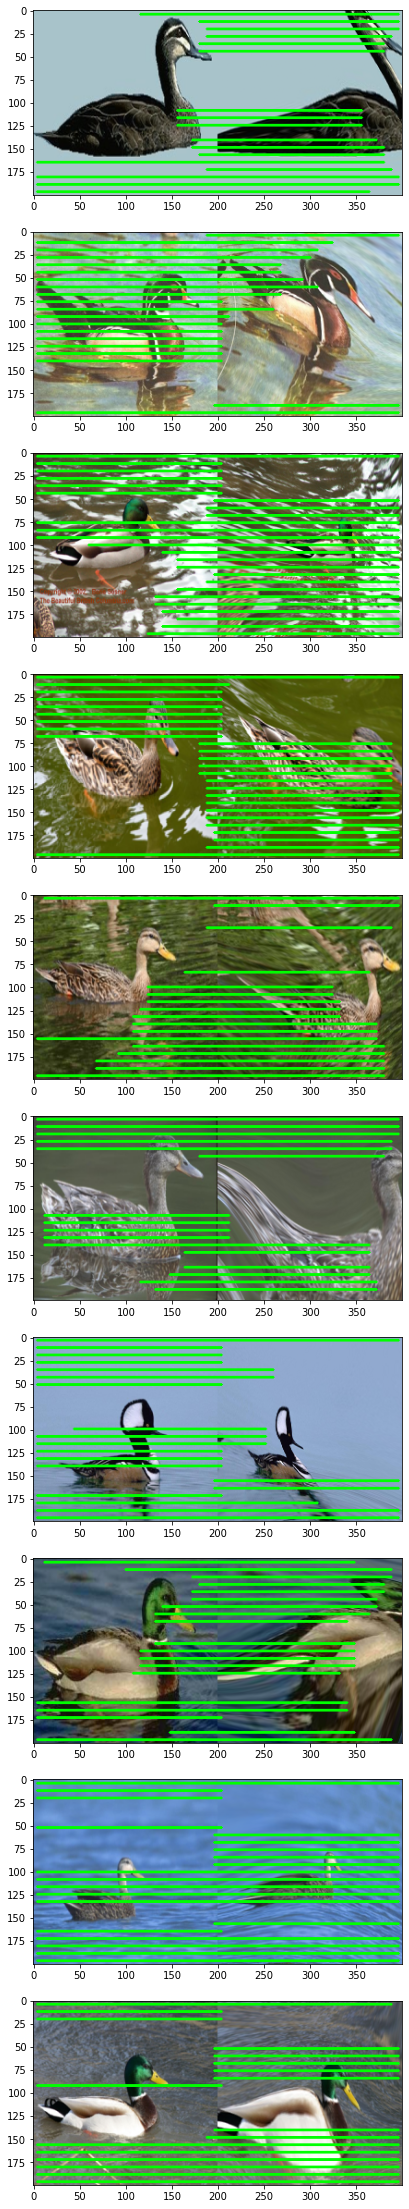

In [24]:
fig = plt.figure(figsize=(20, 40))
for i, (img1, img2) in enumerate(zip(A,B)):
    img1, img2 = img1.numpy(), img2.numpy()
    img1, img2 = restore_original_image_from_array(img1)/255., restore_original_image_from_array(img2)/255.
    coords = matches[matches[:,0]==i][:,1:]
    campus = draw_matches(img1, img2, (25,25), coords.numpy())
    fig.add_subplot(10,1,i+1).imshow(campus)
plt.show()

In [ ]:
img2.shape

In [ ]:
plt.imshow(campus)

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds, correlations = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    